## This notebook makes vector figure as examples to include in the paper.

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from scipy.special import erf
from scipy.signal import savgol_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
font = {'family' : 'Arial',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'stix'
from IPython.display import display, clear_output
import time as systime
sys.path.append('../')
import DataProcessing.utils.TwoDimTTC as TwoDimTTC
from DataProcessing.utils.coortrans import coortrans
coortrans = coortrans()
from visual_utils import *
from GaussianProcessRegression.training_utils import *

path_raw = '../Data/RawData/'
path_processed = '../Data/ProcessedData/'
path_input = '../Data/InputData/'
path_output = '../Data/OutputData/'
fig_path = r'C:/SURFdrive/PhD progress/PhDResearch/4_Conflict/AMAR/Figures/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
if device=='cpu':
    num_threads = torch.get_num_threads()
    print(f'Number of available threads: {num_threads}')
    torch.set_num_threads(round(num_threads/2))

Using cpu device
Number of available threads: 4


### Load trained model

In [2]:
beta = 5
num_inducing_points = 100
model_idx = 53
pipeline = train_val_test(device, num_inducing_points, path_input, path_output)
pipeline.model.load_state_dict(torch.load(path_output+f'trained_models/highD_LC/beta={beta}/model_{model_idx}epoch.pth', map_location=torch.device(device)))
pipeline.likelihood.load_state_dict(torch.load(path_output+f'trained_models/highD_LC/beta={beta}/likelihood_{model_idx}epoch.pth', map_location=torch.device(device)))
pipeline.model.eval()
pipeline.likelihood.eval()
model = pipeline.model.to(device)
likelihood = pipeline.likelihood.to(device)

### Near-crashes 100Car NDS

In [6]:
# Read data
events = pd.read_hdf(path_output + 'conflict_probability/optimal_warning/NearCrashes.h5', key='data')
meta = pd.read_csv(path_output + 'conflict_probability/optimal_warning/Unified_NearCrashes.csv').set_index('trip_id')
proximity_phi = pd.read_csv(path_output+'conflict_probability/proximity_phi.csv')

n = 13
trip_id = 8332
t = -4.4 # -4.4 and -2.0

In [ ]:
df = events[events['trip_id']==trip_id].sort_values('time').reset_index(drop=True)
df = df.merge(proximity_phi, on=['trip_id','time'])
df['s_centroid'] = np.sqrt((df['x_i'] - df['x_j']) ** 2 + (df['y_i'] - df['y_j']) ** 2)
df['probability'] = extreme_cdf(df['s_centroid'].values, df['mu'].values, df['sigma'].values, n)
moment = meta.loc[trip_id]['moment']
df['time'] = np.round(df['time'] - moment, 2)
conflict_start = df[df['event']]['time'].min()
conflict_end = df[df['event']]['time'].max()

df['delta_v'] = np.sqrt((df['vx_i']-df['vx_j'])**2 + (df['vy_i']-df['vy_j'])**2)
df['delta_v2'] = df['delta_v']**2
df['speed_i2'] = df['speed_i']**2
df['speed_j2'] = df['speed_j']**2
features = ['length_i','length_j','hx_j','hy_j','delta_v','delta_v2','speed_i2','speed_j2','acc_i','rho']
df_view_i = coortrans.transform_coor(df, view='i')
heading_j = df_view_i[['time','hx_j','hy_j']]
df_view_i = df_view_i.set_index('time')
df_relative = coortrans.transform_coor(df, view='relative')
rho = coortrans.angle(1, 0, df_relative['x_j'], df_relative['y_j']).reset_index().rename(columns={0:'rho'})
rho['time'] = df_relative['time']
df_relative = df_relative.set_index('time')
interaction_situation = df.drop(columns=['hx_j','hy_j']).merge(heading_j, on='time').merge(rho, on='time')
interaction_situation = interaction_situation[features+['time']].set_index('time')

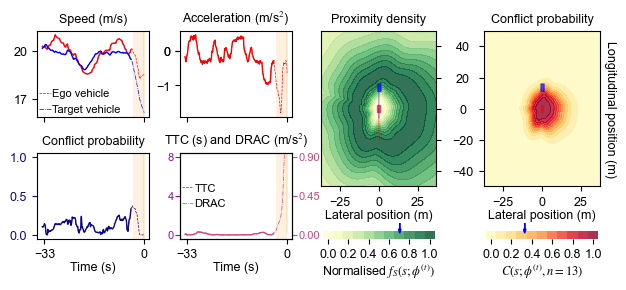

In [7]:
fig = viual_100Car(t, df, df_view_i, df_relative, interaction_situation, 
                   model, likelihood, device, n, conflict_start, conflict_end)

In [8]:
fig.savefig(fig_path+f'ProbEst_{trip_id}_{round(t*100)}.pdf', dpi=600, bbox_inches='tight')

### Lane-changes highD

In [3]:
metadatafiles =  sorted(glob.glob(path_raw + 'highD/RecordingMetadata/*.csv'))
metadata = []
for metadatafile in metadatafiles:
    df = pd.read_csv(metadatafile)
    metadata.append(df)
metadata = pd.concat(metadata).set_index('id')

def ricker_wavelet_gradient(x, a=10):
    """
    Calculate the gradient of smoothed Ricker wavelet function

    Parameters:
    x (float): The lateral velocities at which to evaluate the wavelet.
    a (float): The width parameter of the wavelet. Default is 10Hz as we have downsampled highD data to 10fps.
    """
    coefficient = 2/(np.sqrt(3*a)*(np.pi**0.25))
    ricker_wavelet = coefficient * (1 - (x/a)**2) * np.exp(-0.5*(x/a)**2)
    smoothed_wavelet = savgol_filter(ricker_wavelet, 30, 3)
    gradient = np.gradient(smoothed_wavelet)
    return gradient

loc_id = 1
veh_id_i = 291860
veh_id_j = 291858

In [4]:
data = pd.read_hdf(path_processed+'highD/highD_'+str(loc_id).zfill(2)+'.h5', key='data')
data = data.sort_values(['track_id','frame_id']).set_index('track_id')

meta_tracks = []
for fileid in metadata[metadata['locationId']==loc_id].index:
    meta_track = pd.read_csv(path_raw+'highD/01_tracksMeta.csv')
    meta_track['id'] = (fileid*10000 + meta_track['id']).astype(int)
    meta_tracks.append(meta_track)
meta_tracks = pd.concat(meta_tracks)

lane_markings = [float(y) for lane in ['lowerLaneMarkings','upperLaneMarkings'] for y in metadata.loc[veh_id_i//10000][lane].split(';')]
lane_markings = np.sort(lane_markings)

In [5]:
veh_i = data.loc[veh_id_i]
lane_change_points = veh_i[abs(veh_i['laneId'].diff())>0]['frame_id'].values
frame_segments = np.concatenate(([veh_i['frame_id'].min()], 
                                 (lane_change_points[1:] + lane_change_points[:-1])/2, 
                                 [veh_i['frame_id'].max()]))
frame_start = frame_segments[0]
frame_end = frame_segments[-1]

In [6]:
veh_i = data.loc[veh_id_i]
veh_i = veh_i[veh_i['frame_id'].between(frame_start, frame_end)].drop(columns=['laneId','precedingId', 'followingId'])
veh_j = data.loc[veh_id_j].drop(columns=['laneId','precedingId', 'followingId'])
df = veh_i.merge(veh_j, on='frame_id', suffixes=('_i', '_j'), how='inner')
df['time'] = np.round((df['frame_id'] - df['frame_id'].min())/10, 1)
df['delta_v'] = np.sqrt((df['vx_i']-df['vx_j'])**2 + (df['vy_i']-df['vy_j'])**2)
df['delta_v2'] = df['delta_v']**2
df['speed_i2'] = df['speed_i']**2
df['speed_j2'] = df['speed_j']**2
df['acc_i'] = df['ax_i']*df['hx_i'] + df['ay_i']*df['hy_i']
df['s_centroid'] = np.sqrt((df['x_i']-df['x_j'])**2 + (df['y_i']-df['y_j'])**2)
df['TTC'] = TwoDimTTC.TTC(df, 'values')

other_vehs = data[(data['frame_id']>=df['frame_id'].min())&
                    (data['frame_id']<=df['frame_id'].max())&
                    (data.index!=veh_id_i)].reset_index()
df_view_i, other_vehs_view_i = coortrans.TransCoorVis(df.set_index('frame_id').copy(), other_vehs.set_index('frame_id').copy(), relative=False)
df_relative = coortrans.transform_coor(df, view='relative')
heading_j = df_view_i.reset_index()[['frame_id','hx_j','hy_j']]
rho = coortrans.angle(1, 0, df_relative['x_j'], df_relative['y_j']).reset_index().rename(columns={0:'rho'})
rho['frame_id'] = df_relative['frame_id']
features = ['length_i','length_j','hx_j','hy_j','delta_v','delta_v2','speed_i2','speed_j2','acc_i','rho']
interaction_situation = df.drop(columns=['hx_j','hy_j']).merge(heading_j, on='frame_id').merge(rho, on='frame_id')
interaction_situation = interaction_situation[features+['frame_id']].set_index('frame_id')

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_dist = model(torch.Tensor(interaction_situation.values).to(device))
    y_dist = likelihood(f_dist)
    mu_list, sigma_list = y_dist.mean.cpu().numpy(), y_dist.variance.sqrt().cpu().numpy()
df['mu'] = mu_list
df['sigma'] = sigma_list
df['n_hat'] = np.log(0.5)/np.log(1-lognormal_cdf(df['s_centroid'], df['mu'], df['sigma']))
df.loc[df['n_hat']<1, 'n_hat'] = 1

wavelet = ricker_wavelet_gradient(abs(veh_i['vy']))
frame_1 = veh_i.iloc[wavelet.argmin()]['frame_id']
frame_2 = veh_i.iloc[wavelet.argmax()]['frame_id']
if frame_1 > frame_2:
    frame_1, frame_2 = frame_2, frame_1
df = df[(df['frame_id']>=frame_1-30)&(df['frame_id']<=frame_2+30)]

print(df['frame_id'].min(), df['frame_id'].max())

2909662 2909763


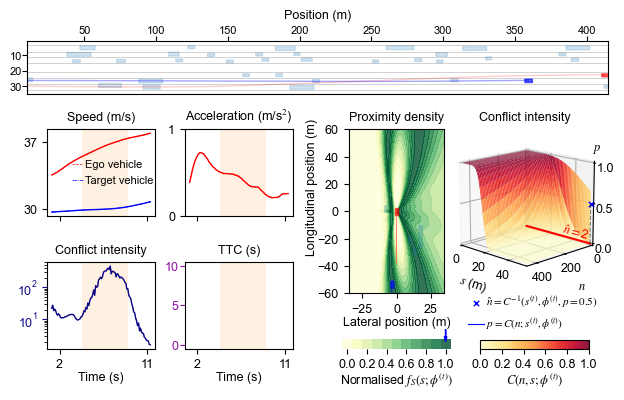

In [13]:
frameid = 2909763 # 2909719 and 2909750

fig = visual_highD(lane_markings, frameid, veh_i, veh_j, df, df_view_i, other_vehs, other_vehs_view_i, 
                   interaction_situation, model, likelihood, device, frame_1, frame_2)

In [12]:
fig.savefig(fig_path+f'IntEva_{loc_id}_{veh_id_i}_{veh_id_j}_{frameid}.pdf', dpi=600, bbox_inches='tight')

In [11]:
fig_path = r'C:/SURFdrive/PhD progress/PhDResearch/4_Conflict/ICTCT2024/VisualExample/Images/'
for frameid in tqdm(df['frame_id'].unique()):
    fig = visual_highD(lane_markings, frameid, veh_i, veh_j, df, df_view_i, other_vehs, other_vehs_view_i, 
                    interaction_situation, model, likelihood, device, frame_1, frame_2)
    fig.savefig(fig_path+f'{loc_id}_{veh_id_i}_{veh_id_j}_{frameid}.png', dpi=600, bbox_inches='tight')
    plt.close(fig)

100%|██████████| 102/102 [05:53<00:00,  3.46s/it]
